In [1]:
# Importanweisungen

import os
import re
import numpy as np
import statistics as stat
import scipy as sci
import scipy.fftpack
import sympy as sym
import matplotlib.pyplot as plt
import matplotlib
import matplotlib.axes as axes
import matplotlib.patches as patches
from matplotlib import colors as mcolors
import math
from scipy import optimize
import uncertainties as unc
import uncertainties.unumpy as unp
import uncertainties.umath as umath
unv=unp.nominal_values
usd=unp.std_devs

import hyperspy.api as hs
import hyperspy.io as io
hs.preferences.GUIs.warn_if_guis_are_missing = False
hs.preferences.save()

In [2]:
# Konstanten fuer einheitliche Darstellung

fig_size = (10, 6)
fig_legendsize = 14
fig_labelsize = 12
matplotlib.rcParams.update({'font.size': fig_labelsize})

colors = dict(mcolors.BASE_COLORS, **mcolors.CSS4_COLORS)
#colors

# mathe Funktionen
def find_nearest_index(array, value):
    array = np.asarray(array)
    idx = (np.abs(array - value)).argmin()
    return idx
def find_nearest(array, value):
    array[find_nearest_index(array,value)]
def normalize(ydata):
   return (ydata-np.amin(ydata))/(np.amax(ydata)-np.amin(ydata))
def mean(n):
    # find the mean value and add uncertainties
    k = np.mean(n)
    err = stat.variance(unv(n))
    return unc.ufloat(unv(k), math.sqrt(usd(k)**2 + err))

def fft(y):
    N = len(y)
    fft = scipy.fftpack.fft(y)
    return 2 * abs(fft[:N//2]) / N

    # allgemeine Fitfunktionen

def linear(x,m): # lineare Funktion mit f(x) = m * x
    return(m*x)

def gerade(x, m, b): # gerade mit = f(x) = m * x + b
    return (m*x + b)

def cyclic(x, a, f, phi):
    return a * np.sin(x * f - phi)

def cyclicOff(x, a, f, phi, offset):
    return cyclic(x, a, f, phi) + offset

def gauss(x, x0, A, d, y0):
    return A * np.exp(-(x - x0)**2 / 2 / d**2) + y0

def exponential(x, c, y0,yy):
    return np.exp(c * x) * y0-yy

def custom(x,y,c):
    return 1/((x-0.066)*c)+y

# fittet ein dataset mit gegebenen x und y werten, eine funktion und ggf. anfangswerten und y-Fehler
# gibt die passenden parameter der funktion, sowie dessen unsicherheiten zurueck
#
# https://stackoverflow.com/questions/14581358/getting-standard-errors-on-fitted-parameters-using-the-optimize-leastsq-method-i#
# Updated on 4/6/2016
# User: https://stackoverflow.com/users/1476240/pedro-m-duarte
def fit_curvefit(datax, datay, function, p0=None, yerr=None, **kwargs):
    pfit, pcov = \
         optimize.curve_fit(function,datax,datay,p0=p0,\
                            sigma=yerr, epsfcn=0.0001, **kwargs)
    error = []
    for i in range(len(pfit)):
        try:
          error.append(np.absolute(pcov[i][i])**0.5)
        except:
          error.append( 0.00 )
    pfit_curvefit = pfit
    perr_curvefit = np.array(error)
    return unp.uarray(pfit_curvefit, perr_curvefit)

# fittet ein dataset mit gegebenen x und y werten, eine funktion und ggf. anfangswerten und y-Fehler
# gibt die passenden parameter der funktion, sowie dessen unsicherheiten zurueck
#
# https://stackoverflow.com/questions/14581358/getting-standard-errors-on-fitted-parameters-using-the-optimize-leastsq-method-i#
# Updated on 4/6/2016
# User: https://stackoverflow.com/users/1476240/pedro-m-duarte
def fit_curvefit2(datax, datay, function, p0=None, yerr=None, **kwargs):
    pfit, pcov = \
         optimize.curve_fit(function,datax,datay,p0=p0,\
                            sigma=yerr, epsfcn=0.0001, **kwargs)
    error = []
    for i in range(len(pfit)):
        try:
          error.append(np.absolute(pcov[i][i])**0.5)
        except:
          error.append( 0.00 )
    pfit_curvefit = pfit
    perr_curvefit = np.array(error)
    return unp.uarray(pfit_curvefit, perr_curvefit)
# usage zB:
# pfit, perr = fit_curvefit(unv(xdata), unv(ydata), gerade, yerr = usd(ydata), p0 = [1, 0])
# fuer eine gerade mit anfangswerten m = 1, b = 0

# weitere Werte, Konstanten
# Werte von https://physics.nist.gov/cuu/Constants/index.html[0]

c = 299792458 # m/s
e = unc.ufloat_fromstr("1.6021766208(98)e-19") # C
k_B = unc.ufloat_fromstr("1.38064852(79)e-23") # J K-1 [0]
h = unc.ufloat_fromstr("4.135667662(25)e-15") # eV s [0]
r_e = unc.ufloat_fromstr("2.8179403227(19)e-15") # m [0]
R = unc.ufloat_fromstr("8.3144598(48)") # J mol-1 K-1 [0]
K = 273.15 # kelvin
g = 9.81 # m/s^2
rad = 360 / 2 / math.pi
grad = 1/rad
# Unsicherheiten
unc_x = 0.002/math.sqrt(3)
unc_y = 0.005/math.sqrt(3)
unc_w = 0.3


In [3]:
%cd ../scripts

/home/leonhard/FestSpekt20/AG-Kohl/scripts


In [4]:
%ls

tem.ipynb


In [5]:
%cd /home/leonhard/FestSpekt20/AG-Kohl/raw/TEM/20180314_WFP_WSe_S2

/home/leonhard/FestSpekt20/AG-Kohl/raw/TEM/20180314_WFP_WSe_S2


In [6]:
import glob
import types
namelist = glob.glob("*.dm3")
print(namelist)

['WSe_S2_df_001.dm3', 'WSe_S2_hrtem_004.dm3', 'WSe_S2_eels_zeroloss_010.dm3', 'WSe_S2_eels_lowloss_008.dm3', 'WSe_S2_bf_001.dm3', 'WSe_S2_hrtem_007.dm3', 'WSe_S2_hrtem_003.dm3', 'WSe_S2_hrtem_006.dm3', 'WSe_S2_hrtem_005.dm3', 'WSe_S2_diff_002.dm3', 'WSe_S2_eels_coreloss_009.dm3']


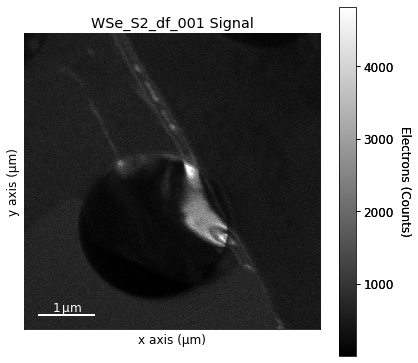

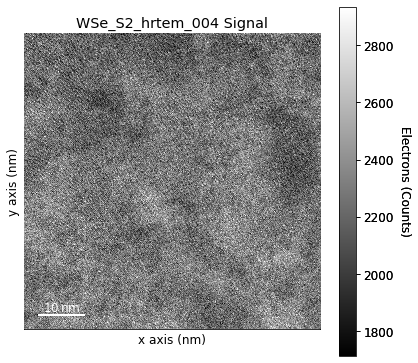

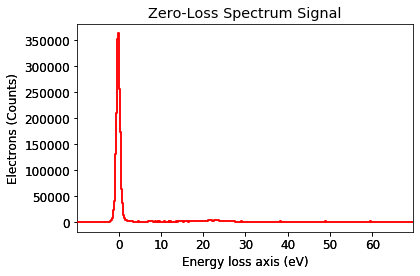

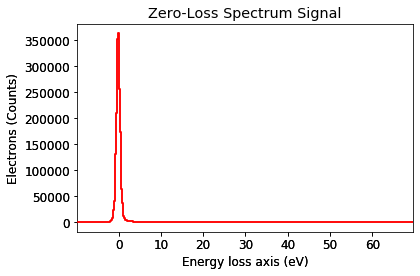

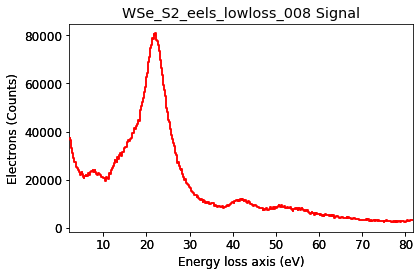

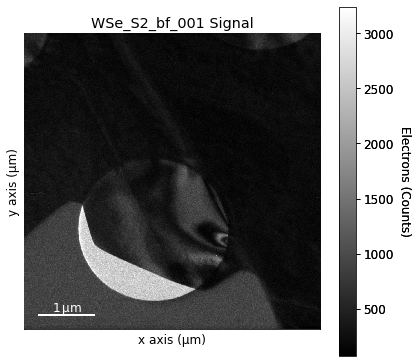

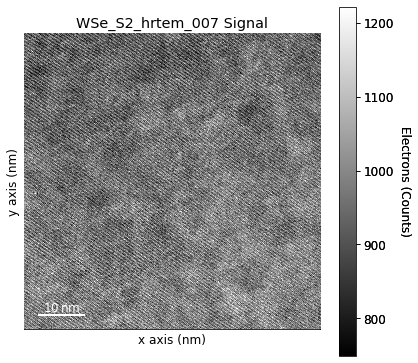

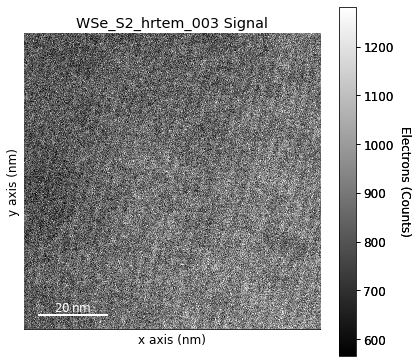

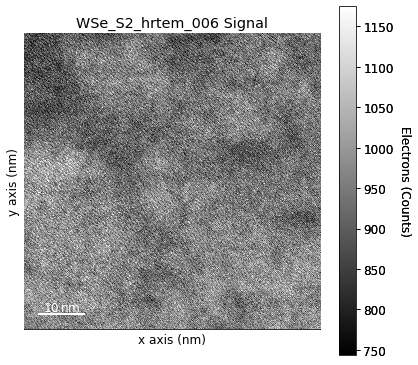

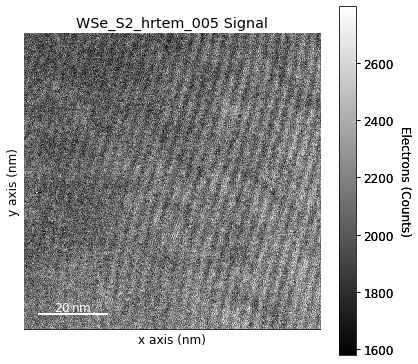

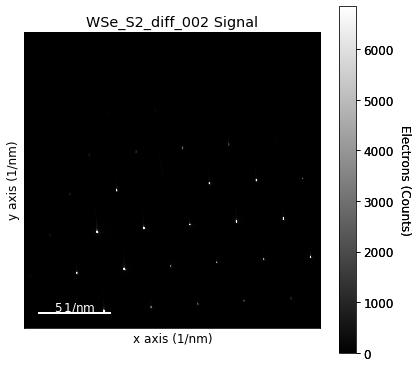

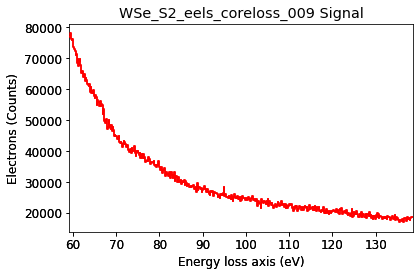

In [9]:
for i,name in enumerate(namelist):
    #name = namelist[2]
    s = hs.load(name)
#s.metadata.General.title = titlelist[i]
    if(not isinstance(s, list)):
        s.plot()
    else:
        for subpic in s:
            subpic.plot()
# die listen sind mehrere Bilder!